In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style("darkgrid")

In [2]:
data = pd.read_csv('Breast_cancer_data.csv')

In [3]:
data.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


In [6]:
data.shape

(569, 6)

## exploratory data analysis


<AxesSubplot:>

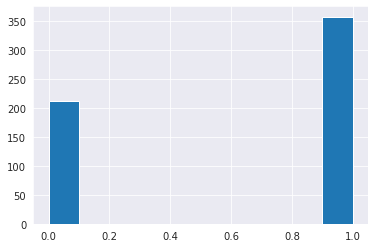

In [7]:
data['diagnosis'].hist()

the data is currently unbalanced 

### one of the hypotheses of naive bayes , the features must be independant 

<AxesSubplot:>

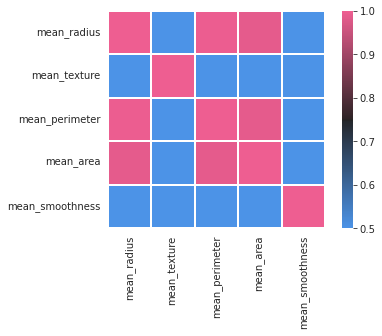

In [8]:
corr = data.iloc[:,:-1].corr(method ="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr,vmax=1,vmin=0.5,cmap = cmap,square = True, linewidths=0.2)

perimeter and raduis are highly correlated 
area and raduis are also highly correlated 

So to apply naive bayes we might need to work with only one variable : raduis - perimeter or area

<AxesSubplot:xlabel='mean_perimeter', ylabel='Count'>

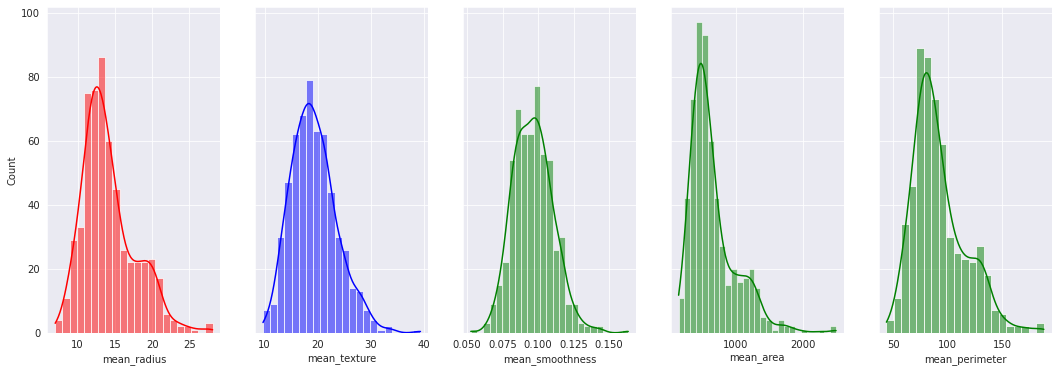

In [17]:
fig, axes = plt.subplots(1,5,figsize = (18,6),sharey=True)
sns.histplot(data,ax=axes[0],x='mean_radius',kde=True,color='r')
sns.histplot(data,ax=axes[1],x='mean_texture',kde=True,color='b')
sns.histplot(data,ax=axes[2],x='mean_smoothness',kde=True,color='g')
sns.histplot(data,ax=axes[3],x='mean_area',kde=True,color='g')
sns.histplot(data,ax=axes[4],x='mean_perimeter',kde=True,color='g')


mean_smoothness and mean_texture kind of follow the normal distribution 
mean_raduis doesn't follow a normal distribution but for sake of simplicity i am going to fit a normal distribution on this variable too 

### code a naive bayes algo


In [9]:
def calculate_prior(df,Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes :
        prior.append(len(df[df[Y]==i])/len(df))
    return prior

In [10]:
def calculate_likelihood_gaussian(df,feat_name,feat_val,Y,label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean,std = df[feat_name].mean() , df[feat_name].std()
    px_given_y = (1/(np.sqrt(2*np.pi)*std)) * np.exp(-((feat_val-mean)**2/(2*std**2)))
    return px_given_y

In [11]:
def naive_bayes_gaussian(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred) 

### test the model with all variables 

In [12]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
print(X_test.shape)
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

(114, 5)
[[36  4]
 [ 2 72]]
0.9599999999999999


### test the model with the variables mean_radius - mean_texture and mean smoothness which are not correlated 

In [13]:
data2 = data[['mean_radius','mean_texture','mean_smoothness','diagnosis']]

In [14]:
data2.head(10)

,mean_radius,mean_texture,mean_smoothness,diagnosis
0,17.99,10.38,0.11840,0
1,20.57,17.77,0.08474,0
2,19.69,21.25,0.10960,0
3,11.42,20.38,0.14250,0
4,20.29,14.34,0.10030,0
5,12.45,15.70,0.12780,0
6,18.25,19.98,0.09463,0
7,13.71,20.83,0.11890,0
8,13.00,21.82,0.12730,0
9,12.46,24.04,0.11860,0


In [16]:
from sklearn.model_selection import train_test_split
train2, test2 = train_test_split(data2, test_size=.2, random_state=41)


X_test2 = test2.iloc[:,:-1].values
Y_test2 = test2.iloc[:,-1].values
Y_pred2 = naive_bayes_gaussian(train2, X=X_test2, Y="diagnosis")
print(X_test2.shape)
from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test2, Y_pred2))
print(f1_score(Y_test2, Y_pred2))

(114, 3)
[[36  4]
 [ 0 74]]
0.9736842105263158
